
# 🥊 UFC Style Analysis — Notebook (Auto-Detect Excel + UAM vs Weighted)

This notebook analyzes **UFC fighting styles**: representation, win ratios, champion conversion rates, and cross-source comparisons (your data vs ESPN).  
It **auto-detects your Excel file** and includes **Unweighted Arithmetic Mean (UAM)** vs **Weighted Average** for win ratios.


In [1]:

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)


In [2]:

# Auto-detect the UFC Excel file in common locations or anywhere in the repo
candidates = [
    "../data/UFC Fighters (3_2022).xlsx"
]

EXCEL_PATH = None
for c in candidates:
    if os.path.exists(c):
        EXCEL_PATH = c
        break

if EXCEL_PATH is None:
    matches = glob.glob("**data/UFC Fighters (3_2022)*.xlsx", recursive=True)
    if matches:
        EXCEL_PATH = matches[0]

if EXCEL_PATH is None:
    raise FileNotFoundError("Could not find the UFC Fighters Excel file. Please add it to the repo or update the search patterns.")

print("Using Excel file:", EXCEL_PATH)


Using Excel file: ../data/UFC Fighters (3_2022).xlsx


In [15]:

def a1_to_ix(a1: str):
    import re
    m = re.match(r"^\s*([A-Za-z]+)(\d+)\s*$", a1)
    if not m: raise ValueError(f'Bad A1 address: {a1}')
    col_s, row_s = m.groups()
    col = 0
    for ch in col_s.upper():
        col = col*26 + (ord(ch)-64)
    return int(row_s)-1, col-1

def parse_range(df: pd.DataFrame, rng: str):
    a, b = [x.strip() for x in rng.split(':')]
    r1,c1 = a1_to_ix(a)
    r2,c2 = a1_to_ix(b)
    return df.iloc[min(r1,r2):max(r1,r2)+1, min(c1,c2):max(c1,c2)+1]

def to_num(x):
    return pd.to_numeric(pd.Series(x).astype(str).str.replace('%','', regex=False), errors='coerce')

def exclude_summary(labels):
    lab = pd.Series(labels).astype(str).str.lower()
    return ~lab.str.contains(r"\b(?:avg|average|overall|total|mean)\b", regex=True)


In [4]:

xls = pd.ExcelFile(EXCEL_PATH)
xls.sheet_names


['Fighters from 11-1993 to 3-2022', 'Cross Source Analysis']

In [5]:

base = pd.read_excel(EXCEL_PATH, sheet_name=0, header=None)


## 1) Style Representation

In [6]:

names_rep = parse_range(base, 'C1:L1').values.flatten().tolist()
vals_rep  = parse_range(base, 'C2:L2').values.flatten().tolist()
rep_df = pd.DataFrame({'Style': names_rep, 'Representation_raw': to_num(vals_rep)}).dropna(subset=['Style'])
rep_df


,Style,Representation_raw
0,Wrestling,420
1,BJJ,183
2,Judo,65
3,Freestyle,477
4,Muay Thai,55
5,Karate,67
6,Kickboxing,73
7,Boxing,48
8,TKD,38
9,Kung Fu,15


In [7]:

rep_raw = rep_df['Representation_raw']
if rep_raw.max() > 1.0 and rep_raw.max() <= 100.0:
    rep_df['Representation_pct'] = rep_raw
    rep_note = '(interpreted as %)'
elif rep_raw.max() <= 1.0:
    rep_df['Representation_pct'] = rep_raw * 100.0
    rep_note = '(converted from proportion)'
else:
    total = rep_raw.sum()
    rep_df['Representation_pct'] = (rep_raw / total) * 100.0 if total else rep_raw
    rep_note = '(normalized to % of total)'
rep_note, rep_df[['Style','Representation_pct']].sort_values('Representation_pct', ascending=False).head()


('(normalized to % of total)',
         Style  Representation_pct
 3   Freestyle           33.102012
 0   Wrestling           29.146426
 1         BJJ           12.699514
 6  Kickboxing            5.065926
 5      Karate            4.649549)

<Figure size 640x480 with 0 Axes>

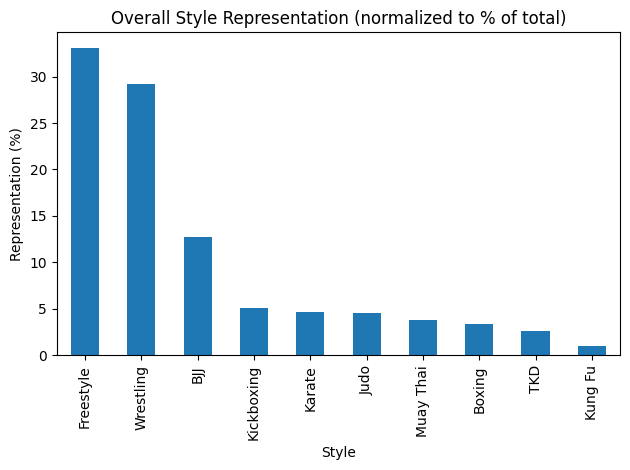

In [8]:

plt.figure()
rep_df.sort_values('Representation_pct', ascending=False).plot(
    x='Style', y='Representation_pct', kind='bar', legend=False
)
plt.ylabel('Representation (%)')
plt.title(f'Overall Style Representation {rep_note}')
plt.tight_layout()
plt.show()


## 2) Win Ratios by Style — **UAM vs Weighted**

In [9]:

# Win ratios: B1:L1 (style names), B6:L6 (values)
names_win = parse_range(base, 'B1:L1').values.flatten().tolist()
vals_win  = parse_range(base, 'B6:L6').values.flatten().tolist()
win_df = pd.DataFrame({'Style': names_win, 'Win_Ratio': to_num(vals_win)}).dropna(subset=['Style'])

# Fighter counts for weights (reuse styles from C1:L1 and counts from C2:L2)
fighters = parse_range(base, 'C2:L2').values.flatten().tolist()
fighters_df = pd.DataFrame({'Style': names_rep, 'Fighters': to_num(fighters)})

# Merge and exclude summary labels if any
win_w = win_df.merge(fighters_df, on='Style', how='left')
mask = exclude_summary(win_w['Style'])

# Compute UAM and Weighted Average
uam = win_w.loc[mask, 'Win_Ratio'].mean()
if win_w.loc[mask, 'Fighters'].fillna(0).sum() > 0:
    wavg = np.average(win_w.loc[mask, 'Win_Ratio'], weights=win_w.loc[mask, 'Fighters'].fillna(0))
else:
    wavg = np.nan

avg_comparison = pd.DataFrame({
    'Metric': ['UAM (Unweighted Arithmetic Mean)', 'Weighted Average (by Fighters)'],
    'Win Ratio': [uam, wavg]
})
avg_comparison


,Metric,Win Ratio
0,UAM (Unweighted Arithmetic Mean),1.285946
1,Weighted Average (by Fighters),1.242443


<Figure size 640x480 with 0 Axes>

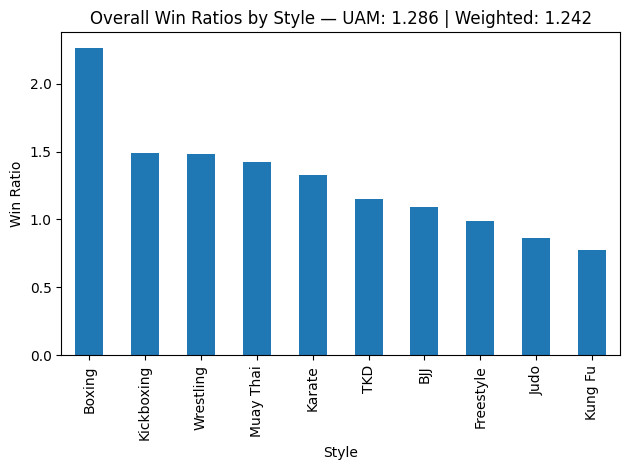

In [10]:

plt.figure()
win_w.loc[mask].sort_values('Win_Ratio', ascending=False).plot(
    x='Style', y='Win_Ratio', kind='bar', legend=False
)
plt.ylabel('Win Ratio')
plt.title(f'Overall Win Ratios by Style — UAM: {uam:.3f} | Weighted: {wavg:.3f}')
plt.tight_layout()
plt.show()



> **Why they differ:** UAM gives each style equal weight regardless of size.  
> Weighted average gives each style weight proportional to its **number of fighters**. If one style dominates headcount, it will pull the weighted average toward its own ratio.


## 3) Champion Conversion Rate by Style — Cross Source Analysis

In [11]:

cross_name = next((nm for nm in xls.sheet_names if 'cross' in nm.lower()), None)
assert cross_name is not None, "Cross Source Analysis sheet not found. Please rename accordingly."

cross = pd.read_excel(EXCEL_PATH, sheet_name=cross_name, header=None)

styles_conv = parse_range(cross, 'A2:A13').values.flatten().tolist()
yours_conv  = to_num(parse_range(cross, 'D2:D13').values.flatten().tolist())
espn_conv   = to_num(parse_range(cross, 'E2:E13').values.flatten().tolist())

conv_df = pd.DataFrame({
    'Style': styles_conv,
    'Conversion_Yours_raw': yours_conv,
    'Conversion_ESPN_raw': espn_conv
}).dropna(subset=['Style'])

# Percent versions
conv_pct = conv_df.copy()
if conv_pct[['Conversion_Yours_raw','Conversion_ESPN_raw']].max().max() <= 1.0:
    conv_pct['Conversion_Yours_pct'] = conv_pct['Conversion_Yours_raw'] * 100.0
    conv_pct['Conversion_ESPN_pct']  = conv_pct['Conversion_ESPN_raw'] * 100.0
    conv_note = '(converted from proportion)'
else:
    conv_pct['Conversion_Yours_pct'] = conv_pct['Conversion_Yours_raw']
    conv_pct['Conversion_ESPN_pct']  = conv_pct['Conversion_ESPN_raw']
    conv_note = '(interpreted as %)'
mask_c = exclude_summary(conv_pct['Style'])
avg_y = conv_pct.loc[mask_c, 'Conversion_Yours_pct'].mean()
avg_e = conv_pct.loc[mask_c, 'Conversion_ESPN_pct'].mean()

conv_pct[['Style','Conversion_Yours_pct','Conversion_ESPN_pct']].head()


,Style,Conversion_Yours_pct,Conversion_ESPN_pct
0,Style,NaN,NaN
1,Total,5.34,4.86
2,Wrestling,9.05,6.67
3,BJJ,6.01,9.29
4,Judo,1.54,0.00


<Figure size 640x480 with 0 Axes>

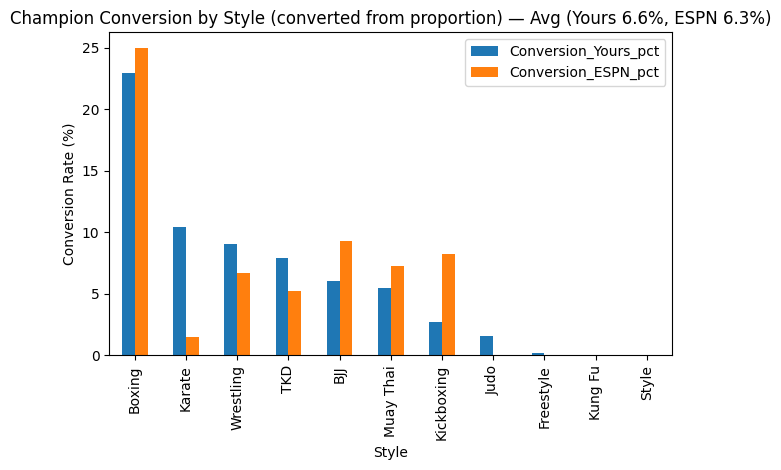

In [12]:

plt.figure()
plot_df = conv_pct.loc[mask_c].set_index('Style')[['Conversion_Yours_pct','Conversion_ESPN_pct']].sort_values('Conversion_Yours_pct', ascending=False)
plot_df.plot(kind='bar')
plt.ylabel('Conversion Rate (%)')
plt.title(f'Champion Conversion by Style {conv_note} — Avg (Yours {avg_y:.1f}%, ESPN {avg_e:.1f}%)')
plt.tight_layout()
plt.show()


## 4) Champion Representation by Style — Cross Source Analysis

In [13]:

styles_rep2 = parse_range(cross, 'A2:A13').values.flatten().tolist()
yours_rep2  = to_num(parse_range(cross, 'B3:B13').values.flatten().tolist())
espn_rep2   = to_num(parse_range(cross, 'C3:C13').values.flatten().tolist())

def pad(lst, n):
    out = list(lst)
    while len(out) < n: out.append(np.nan)
    return out

mx = max(len(styles_rep2), len(yours_rep2), len(espn_rep2))
styles_rep2 = pad(styles_rep2, mx)
yours_rep2  = pad(yours_rep2, mx)
espn_rep2   = pad(espn_rep2, mx)

rep2_df = pd.DataFrame({
    'Style': styles_rep2,
    'Champions_Yours': yours_rep2,
    'Champions_ESPN': espn_rep2
}).dropna(subset=['Style'])

rep2_df.head()


,Style,Champions_Yours,Champions_ESPN
0,Style,77.0,70.0
1,Total,38.0,28.0
2,Wrestling,11.0,17.0
3,BJJ,1.0,0.0
4,Judo,1.0,0.0


<Figure size 640x480 with 0 Axes>

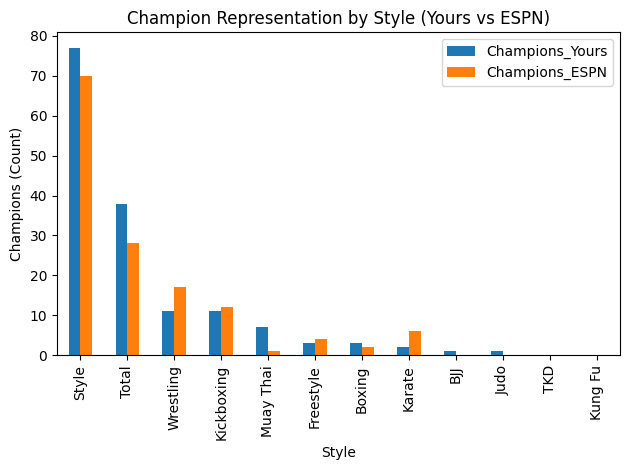

In [14]:

plt.figure()
rep2_plot = rep2_df.set_index('Style')[['Champions_Yours','Champions_ESPN']].sort_values('Champions_Yours', ascending=False)
rep2_plot.plot(kind='bar')
plt.ylabel('Champions (Count)')
plt.title('Champion Representation by Style (Yours vs ESPN)')
plt.tight_layout()
plt.show()



## 🔎 Insights (fill after running)
- Do UAM vs Weighted averages change the ranking or overall narrative?
- Which styles punch above their weight (high conversion with low representation)?
- Where do ESPN vs your dataset diverge most?

## ✅ Conclusions
- 2–3 crisp takeaways here.
- Caveats / next steps (weight classes, time splits, opponent quality).
